## Experiment design

- Create two simple prompts (clean and corrupted) based on a CAA-style Temporal Awareness explicit dataset : *data/raw/temporal_scope_caa.json*. Lets these prompts force model to answer yes/no, to easily calcuate answer's logit difference.
- Clean prompt: <code>"The goal is to make one cup of coffee. Is this a short-term or long-term goal? The answer is:"</code>
- Clean answer: <code>"short"</code>
- Corrupted prompt: <code>"The goal is to become the future Prime Minister. Is this a short-term or long-term goal? The answer is:"</code>
- Corrupted answer: <code>"long"</code>
- 7 examples of such prompts (aligned by number of tokens) were created and put into *temporal_scope_for_attribution_patching_for_phi3.json*
- Run attribution patching as in TransformerLens demo: https://github.com/TransformerLensOrg/TransformerLens/blob/main/demos/Attribution_Patching_Demo.ipynb

## Experiment results

In [ ]:
from pathlib import Path
import sys
import json
import os

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")
except:
  IN_COLAB = False
  print("Not running as a Colab notebook")

if IN_COLAB:
  %pip install transformer_lens
  from google.colab import drive
  drive.mount('/content/drive')
  ! pwd # Returns /content
  ! cp "/content/drive/MyDrive/Colab Notebooks/patching_algorithms.py" /content/patching_algorithms.py
  ! cp "/content/drive/MyDrive/Colab Notebooks/temporal_scope_for_attribution_patching_for_phi3.json" /content/temporal_scope_for_attribution_patching.json
  import patching_algorithms

import plotly.express as px
import plotly.io as pio
import pandas as pd

### 1. Define the model of interest

In [ ]:
MODEL_NAME = "phi-3"

### 2. Read the dataset, prepare inputs

In [ ]:
temporal_dataset = None
dataset_path = "temporal_scope_for_attribution_patching.json"
with open(dataset_path) as f:
    temporal_dataset = json.load(f)

clean_prompts = []
clean_answers = []
corrupted_prompts = []
corrupted_answers = []

for sample in temporal_dataset:
    clean_question = sample["clean"]["question"]
    clean_prompts.append(clean_question)
    clean_answers.append(sample["clean"]["answer"])

    corrupted_question = sample["corrupted"]["question"]
    corrupted_prompts.append(corrupted_question)
    corrupted_answers.append(sample["corrupted"]["answer"])

    # Do mix:
    clean_prompts.append(corrupted_question)
    clean_answers.append(sample["corrupted"]["answer"])
    corrupted_prompts.append(clean_question)
    corrupted_answers.append(sample["clean"]["answer"])


In [ ]:
from transformer_lens import (
    HookedTransformer,
    ActivationCache,
    patching
)

model_name = MODEL_NAME

model = HookedTransformer.from_pretrained(model_name)
model.set_use_attn_result(True)
is_qwen = False
if "Qwen" in model_name:
    model.set_use_split_qkv_input(True)
    is_qwen = True
else:
    model.set_use_attn_in(True)
model.set_use_hook_mlp_in(False)


clean_tokens = model.to_tokens(clean_prompts, prepend_bos=True, padding_side='left')
for i in range(len(clean_prompts)):
  string_tokens = [f"{i}, {model.to_string(t)}" for i, t in enumerate(clean_tokens[i])]
  print(string_tokens)

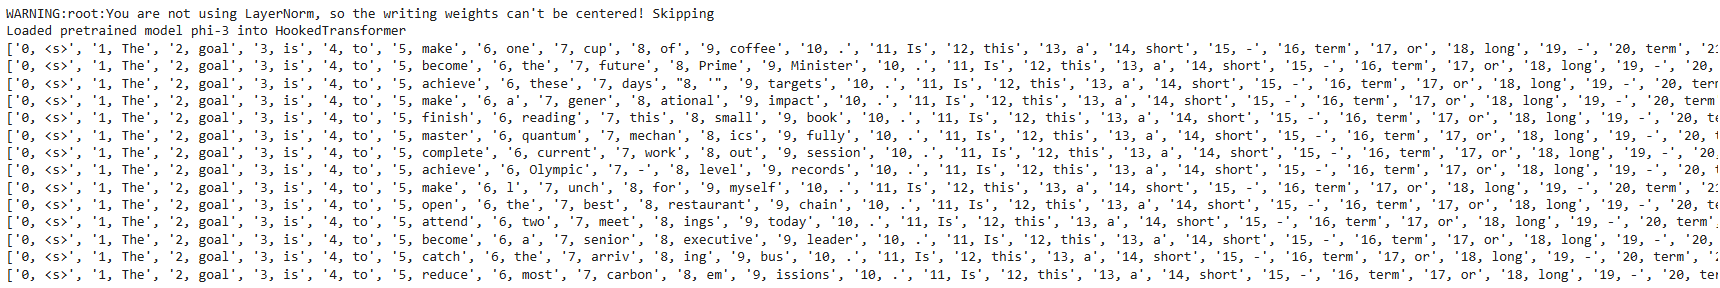

### Run Attribution patching for residual stream

In [ ]:
attr_patch = patching_algorithms.AttributionPatching(MODEL_NAME,
                                                     clean_prompts, clean_answers,
                                                     corrupted_prompts, corrupted_answers)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model phi-3 into HookedTransformer
Clean string 0 <s> The goal is to make one cup of coffee. Is this a short-term or long-term goal? The answer is:
Corrupted string 0 <s> The goal is to become the future Prime Minister. Is this a short-term or long-term goal? The answer is:
Clean answers tensor([3273, 1472, 3273, 1472, 3273, 1472, 3273, 1472, 3273, 1472, 3273, 1472,
        3273, 1472])
Corrupted answers tensor([1472, 3273, 1472, 3273, 1472, 3273, 1472, 3273, 1472, 3273, 1472, 3273,
        1472, 3273])


In [ ]:
residual_attr, residual_labels = attr_patch.patch_residual()

Clean logit TOP-3: ['short <|end|> \n', 'long Long\n', '<|end|> short\n', 'long Long <|end|>', 'short\n <|end|>', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> Long', 'short <|end|> \n', 'long Long\n', 'short Short\n', 'long <|end|> Long']

Corrupted logit TOP-3: ['long Long\n', 'short <|end|> \n', 'long Long <|end|>', '<|end|> short\n', 'long <|end|> \n', 'short\n <|end|>', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> Long', 'short <|end|> \n', 'long Long\n', 'short <|end|> \n', 'long <|end|> Long', 'short Short\n']


Clean logit diff: 4.8895
Corrupted logit diff: -4.8895


In [ ]:
fig = px.imshow(residual_attr, y=residual_labels,
                color_continuous_scale="RdBu",
                color_continuous_midpoint=0.0,
                aspect="auto",
                title="Residual Attribution Patching")
fig.layout.xaxis.title.text = "Position"
fig.layout.yaxis.title.text = "Component"

fig.show()

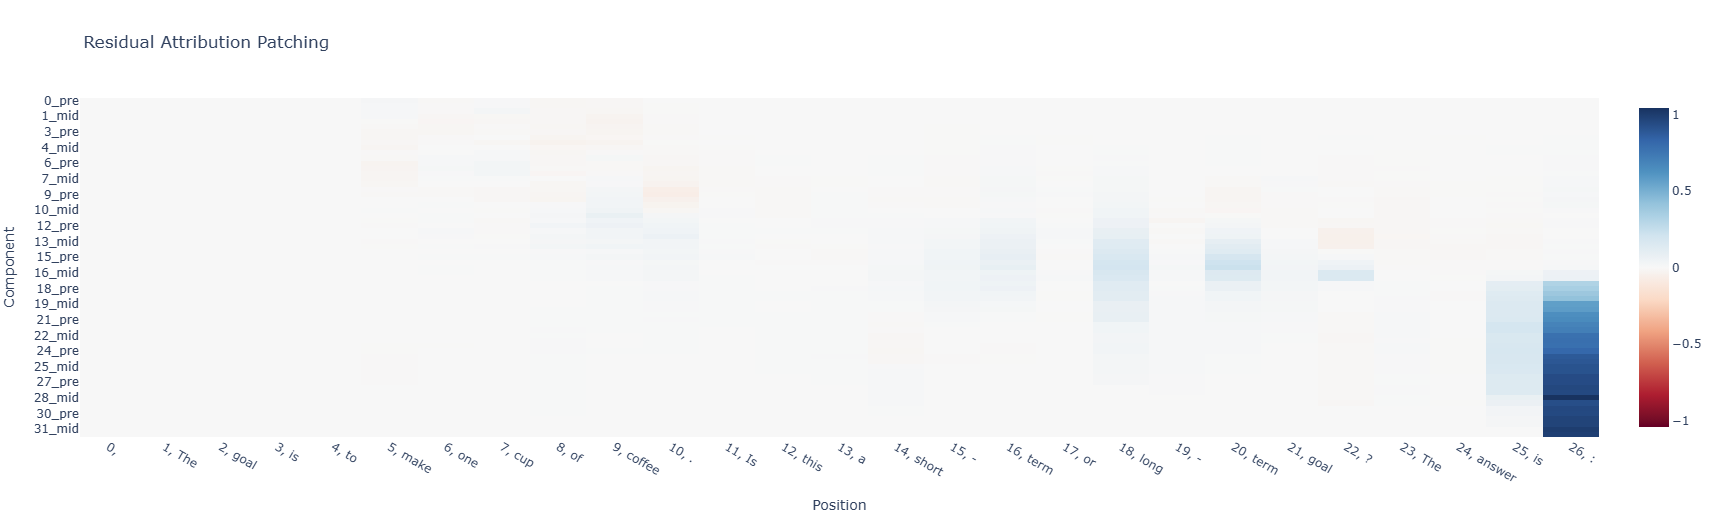

In [ ]:
del residual_attr
del residual_labels

import gc
gc.collect()

162

### Run Attribution patching for attention output stream

In [ ]:
atten_out_attr, atten_out_labels = attr_patch.patch_attn_out()

Clean logit TOP-3: ['short <|end|> \n', 'long Long\n', '<|end|> short\n', 'long Long <|end|>', 'short\n <|end|>', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> Long', 'short <|end|> \n', 'long Long\n', 'short Short\n', 'long <|end|> Long']

Corrupted logit TOP-3: ['long Long\n', 'short <|end|> \n', 'long Long <|end|>', '<|end|> short\n', 'long <|end|> \n', 'short\n <|end|>', 'long <|end|> \n', 'short <|end|> \n', 'long <|end|> Long', 'short <|end|> \n', 'long Long\n', 'short <|end|> \n', 'long <|end|> Long', 'short Short\n']


Clean logit diff: 4.8895
Corrupted logit diff: -4.8895


In [ ]:
fig = px.imshow(atten_out_attr, y=atten_out_labels,
                color_continuous_scale="RdBu",
                color_continuous_midpoint=0.0,
                aspect="auto",
                title="Attention Output Attribution Patching")
fig.layout.xaxis.title.text = "Position"
fig.layout.yaxis.title.text = "Component"

fig.show()

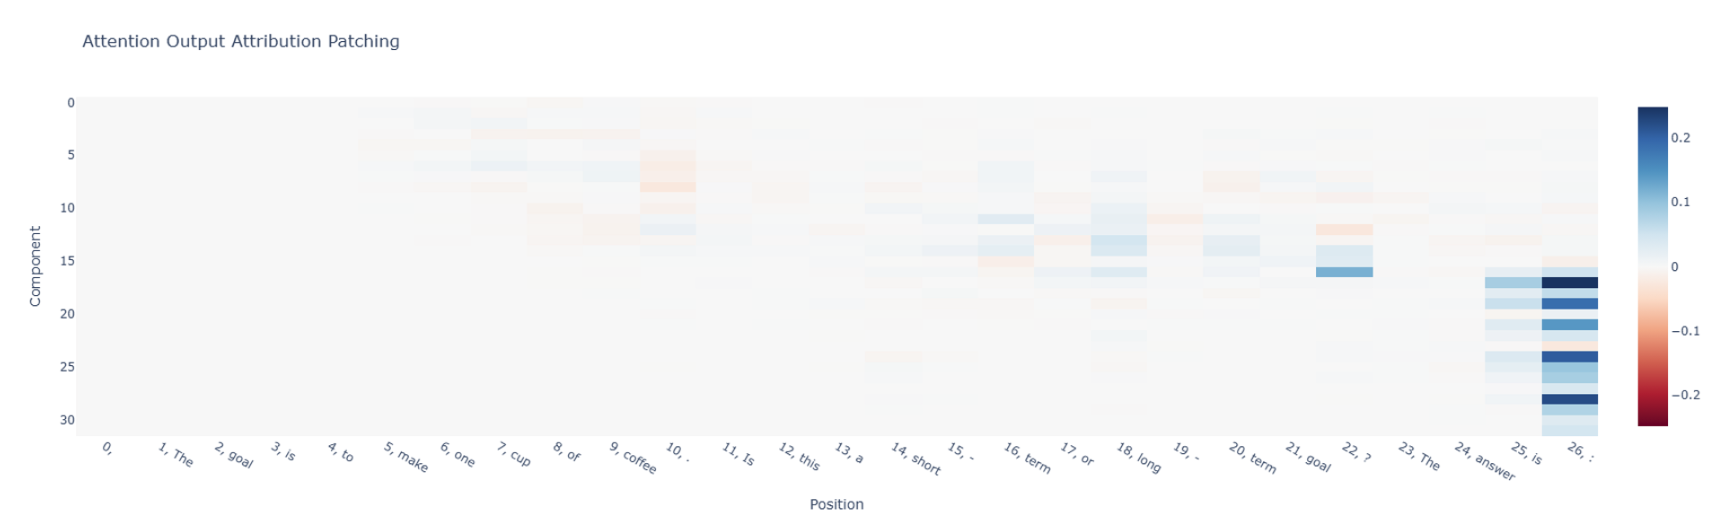

In [ ]:
del attr_patch
del atten_out_attr
del atten_out_labels


import gc
gc.collect()